In [1]:
!pip install tensorflow-addons==0.15
!pip install pydot

You should consider upgrading via the '/Users/olivergiles/.pyenv/versions/3.8.12/envs/lewagon/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/olivergiles/.pyenv/versions/3.8.12/envs/lewagon/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
%load_ext autoreload
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Normalization, concatenate, BatchNormalization
import timeit
from math import pi
import matplotlib.pyplot as plt 
import numpy as np
from numba import vectorize, float64

In [3]:
@vectorize([float64(float64, float64, float64, float64)],cache=True)
def f64_haversine(lon1,lat1,lon2,lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    return 2 * 6371 * asin(sqrt(a))

In [4]:
url = 's3://wagon-public-datasets/taxi-fare-train.csv'
df = pd.read_csv(url, nrows=110_000)
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


# Tensorflow

In [5]:
@tf.function
def tf_radians(x):
    return (pi * x)/180 

@tf.function
def tf_haversine(x):
    x = tf_radians(x)
    dlon = x[:,2] - x[:,0]
    dlat = x[:,3] - x[:,1]
    a = tf.math.sin(dlat / 2) ** 2 + tf.math.cos(x[:,2]) * tf.math.cos(x[:,3]) * tf.math.sin(dlon / 2) ** 2
    return 2 * 6371 * tf.math.asin(tf.math.sqrt(a))

In [6]:
x = np.array([
    [1.0,2.0,3.0,4.0],
    [1.0,2.0,3.0,4.0],
    [1.0,2.0,3.0,4.0],
    [1.0,2.0,3.0,4.0]
])

In [7]:
tf_haversine(x)

2022-05-27 14:06:56.569248: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<tf.Tensor: shape=(4,), dtype=float64, numpy=array([314.22347668, 314.22347668, 314.22347668, 314.22347668])>

In [8]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers.experimental.preprocessing import PreprocessingLayer

class Haversine(PreprocessingLayer):
    def __init__(self, name=None, **kwargs) -> None:
        super(Haversine, self).__init__(name=name, **kwargs)
        self.input_spec = tf.keras.layers.InputSpec(ndim=2)
    
    def call(self, inputs, training=True):
        if training is None:
            training = K.learning_phase()
            
        outputs = tf_haversine(inputs)
        return tf.reshape(outputs, (-1,1))
    
    def compute_output_shape(self, input_shape):
        return 1

In [9]:
hl = Haversine()
y = hl(x)
print(y)

tf.Tensor(
[[314.2235]
 [314.2235]
 [314.2235]
 [314.2235]], shape=(4, 1), dtype=float32)


In [10]:
def init_model_tf():
    inputs = Input(shape=(4,))
    x = Haversine()(inputs)
    x = Dense(8, activation="relu", input_shape=(1,))(x)
    outputs = Dense(1, activation="linear")(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss="mse", optimizer="adam", metrics=["mse"])
    return model

model = init_model_tf()

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 haversine_1 (Haversine)     (None, 1)                 0         
                                                                 
 dense (Dense)               (None, 8)                 16        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [12]:
small_df = df.head(10_000)

In [13]:
%%time
y = small_df.fare_amount
X = small_df[["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]]
model.fit(X, y, epochs=5, batch_size=32, verbose=0)

CPU times: user 3.18 s, sys: 366 ms, total: 3.54 s
Wall time: 3.3 s


In [14]:
def init_model_numba():
    inputs = Input(shape=(1,)) 
    x = Dense(8, activation="relu", input_shape=(1,))(inputs)
    outputs = Dense(1, activation="linear")(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss="mse", optimizer="adam", metrics=["mse"])
    return model

model = init_model_numba()

In [15]:
%%time
y = small_df.fare_amount
X = f64_haversine(small_df["pickup_longitude"], small_df["pickup_latitude"], 
            small_df["dropoff_longitude"], small_df["dropoff_latitude"])
model.fit(X,y, epochs=5, batch_size=32, verbose=0)

CPU times: user 3.35 s, sys: 385 ms, total: 3.74 s
Wall time: 4 s


# Simple example

In [16]:
# Let's make a simpler example
@tf.function
def f(x):
    y = 1/(x**2)
    return y
type(f)

tensorflow.python.eager.def_function.Function

In [17]:
# This is your code re-coded in Tensorflow
print(tf.autograph.to_code(f.python_function))

def tf__f(x):
    with ag__.FunctionScope('f', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()
        y = (1 / (ag__.ld(x) ** 2))
        try:
            do_return = True
            retval_ = ag__.ld(y)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)



In [18]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

from datetime import datetime

# Set up logging.
stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = 'logs/func/%s' % stamp
writer = tf.summary.create_file_writer(logdir)

# Bracket the function call with tf.summary.trace_on() and tf.summary.trace_export().
tf.summary.trace_on()
z = f(100)

with writer.as_default():
    tf.summary.trace_export(
      name="my_func_trace",
      step=0,
      profiler_outdir=logdir)


# Display graph interactively
%tensorboard --logdir logs/func

Reusing TensorBoard on port 6006 (pid 31995), started 15:23:03 ago. (Use '!kill 31995' to kill it.)

# Full example

In [19]:
@tf.function(experimental_follow_type_hints=True)
def fn_seconds_since_1970(date_time: tf.string, date_format: str = "%Y-%m-%d %H:%M:%S %Z"):
    seconds_since_1970 = tfa.text.parse_time(date_time, date_format, output_unit='SECOND')
    seconds_since_1970 = tf.cast(seconds_since_1970, dtype=tf.int64)
    return seconds_since_1970

@tf.function
def get_day_hour(x):
    seconds_in_hour, hours_in_day = tf.constant(3600, dtype=tf.int64), tf.constant(24, dtype=tf.int64)
    hours_since_1970 = x / seconds_in_hour
    hours_since_1970 = tf.cast(hours_since_1970, tf.int64)
    hour_of_day = hours_since_1970 % hours_in_day
    days_since_1970 = x / (seconds_in_hour * hours_in_day)                                                                                                                        
    days_since_1970 = tf.cast(days_since_1970, tf.int64)                                                                                                                               
    day_of_week = (days_since_1970 + 4) % 7 
    return day_of_week, hour_of_day

@tf.function
def sin_transformation(x, period):
    return tf.sin(x / period * 2 * pi)
    
@tf.function
def cos_transformation(x, period):
    return tf.cos(x / period * 2 * pi)

@tf.function
def get_time_features(x):
    seconds_since_1970 = fn_seconds_since_1970(x)
    day_of_week, hour_of_day = get_day_hour(seconds_since_1970)
    return tf.stack([sin_transformation(day_of_week, 7), cos_transformation(day_of_week, 7), sin_transformation(hour_of_day, 24), cos_transformation(hour_of_day, 24)],axis=1)

In [20]:
class TimeFeatures(PreprocessingLayer):
    def __init__(self, name=None, **kwargs) -> None:
        super(TimeFeatures, self).__init__(name=name, **kwargs)
        self.input_spec = tf.keras.layers.InputSpec(ndim=2)
    
    def call(self, inputs, training=True):
        if training is None:
            training = K.learning_phase()
            
        outputs = get_time_features(inputs)
        return tf.reshape(outputs, (-1,4))
    
    def compute_output_shape(self):
        return 4

In [21]:
def init_model():
    time_input = Input(shape=(1,),dtype="string",name="time")
    x = TimeFeatures()(time_input)
    x = Dense(40)(x)
    x = Dense(20)(x)
    time_output = Dense(10)(x)

    distance_input = Input(shape=(4,), name="distance")
    y = Haversine()(distance_input)
    y = Dense(20)(y)
    distance_output = Dense(10)(y)

    numerical_input = Input(shape=(1,), name="numerical")
    z = Normalization()(numerical_input)
    z = Dense(10)(z)
    numerical_output = Dense(10)(z)

    combination = concatenate([time_output, distance_output, numerical_output])
    t = Dense(10)(combination)
    output = Dense(1, activation="linear")(t)

    model = Model(
    inputs=[time_input, distance_input, numerical_input],
    outputs=output
    )

    model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mse"]
    )

    return model

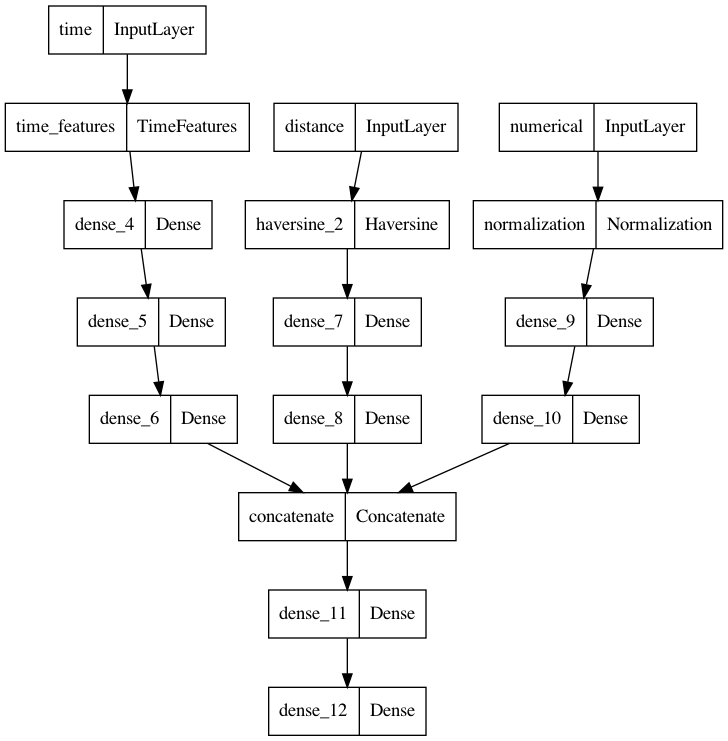

In [22]:
model = init_model()
plot_model(model)

In [23]:
es = EarlyStopping(monitor="val_mse", patience=5, restore_best_weights=True)

In [24]:
test_df = df.tail(100_000)
df = df.head(10_000)

In [25]:
history = model.fit(
x={
    "time": df["pickup_datetime"], 
    "distance": df[["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]], 
    "numerical": df["passenger_count"]
},
y=df["fare_amount"],
batch_size=32,
epochs=5,
callbacks=[es],
validation_split=0.3,
verbose=0
)

In [26]:
%%time
model.predict({
"time": test_df["pickup_datetime"], 
"distance": test_df[["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]], 
"numerical": test_df["passenger_count"]
})

CPU times: user 9.59 s, sys: 807 ms, total: 10.4 s
Wall time: 7.39 s


array([[14.102963 ],
       [10.642104 ],
       [ 9.917615 ],
       ...,
       [10.127873 ],
       [13.2417965],
       [10.765684 ]], dtype=float32)

In [29]:
%%time
model.__call__({
"time": test_df["pickup_datetime"].values, 
"distance": test_df[["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]].values, 
"numerical": test_df["passenger_count"].values
})

CPU times: user 203 ms, sys: 69.1 ms, total: 272 ms
Wall time: 234 ms


<tf.Tensor: shape=(100000, 1), dtype=float32, numpy=
array([[14.102963 ],
       [10.642104 ],
       [ 9.917615 ],
       ...,
       [10.127873 ],
       [13.2417965],
       [10.765685 ]], dtype=float32)>

In [28]:
%%time
model({
"time": test_df["pickup_datetime"].values, 
"distance": test_df[["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]].values, 
"numerical": test_df["passenger_count"].values
})

CPU times: user 203 ms, sys: 65.3 ms, total: 268 ms
Wall time: 217 ms


<tf.Tensor: shape=(100000, 1), dtype=float32, numpy=
array([[14.102963 ],
       [10.642104 ],
       [ 9.917615 ],
       ...,
       [10.127873 ],
       [13.2417965],
       [10.765685 ]], dtype=float32)>